In [14]:
import requests
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from pandas import read_csv
from sklearn.preprocessing import LabelEncoder
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from numpy import concatenate
from pandas import DataFrame

In [15]:
# The path to our CSV file
file = "../data/csv/Gold_Data.csv"
df = pd.read_csv(file)
df.head()

,Business_Week,Gold_Change,Gold_Settle,Gold_Volume,Gold_Prev. Day Open Interest,Date,Open Interest,Ten_Yr_Futures_Change,Ten_Yr_Futures_Settle,Ten_Yr_Futures_Volume,...,USD_Change,USD_Settle,USD_Volume,USD_Wave,USD_Prev. Day Open Interest,ZAR_Change,ZAR_Settle,ZAR_Volume,ZAR_Wave,ZAR_Prev. Day Open Interest
0,"[2006-06-07, 2006-06-11]",NaN,614.900000,466.000000,533.000000,2006-06-13,382474.0,NaN,105.807292,45881.666667,...,0.343333,85.516667,6773.333333,NaN,32902.333333,-0.015500,6.747000,42.000000,NaN,2322.000000
1,"[2006-06-14, 2006-06-18]",NaN,568.933333,127.333333,209.666667,2006-06-20,390281.0,NaN,105.166667,11343.000000,...,-0.166667,86.050000,1183.333333,NaN,16401.666667,0.002333,6.887167,67.666667,NaN,2295.333333
2,"[2006-06-21, 2006-06-25]",NaN,584.833333,31.000000,111.000000,2006-06-27,384321.0,NaN,104.416667,484509.666667,...,0.230000,85.933333,6513.000000,NaN,22332.000000,0.147250,7.430000,618.000000,NaN,2672.000000
3,"[2006-06-28, 2006-07-02]",NaN,594.400000,31923.666667,114519.000000,2006-07-03,392868.0,NaN,104.447917,787568.333333,...,-0.400000,85.556667,4592.000000,NaN,18126.000000,-0.056333,7.224500,38.000000,NaN,2013.000000
4,"[2006-07-05, 2006-07-09]",NaN,633.600000,42120.333333,174046.666667,2006-07-11,427008.0,NaN,104.536458,913654.666667,...,-0.053333,84.973333,3274.666667,NaN,16581.333333,0.030833,7.198667,253.000000,NaN,2043.333333


In [16]:
#new = old.filter(['A','B','D'], axis=1)

df1 = df.filter(['Date','Gold_Settle','USD_Settle','Ten_Yr_Futures_Settle','ZAR_Settle'], axis=1)

In [17]:
#raw_data['Mycol'] =  pd.to_datetime(raw_data['Mycol'], format='%d%b%Y:%H:%M:%S.%f')

df1['Date'] = pd.to_datetime(df1['Date'])
df1.set_index('Date', inplace = True)

In [18]:
df1.head()

,Gold_Settle,USD_Settle,Ten_Yr_Futures_Settle,ZAR_Settle
Date,,,,
2006-06-13,614.900000,85.516667,105.807292,6.747000
2006-06-20,568.933333,86.050000,105.166667,6.887167
2006-06-27,584.833333,85.933333,104.416667,7.430000
2006-07-03,594.400000,85.556667,104.447917,7.224500
2006-07-11,633.600000,84.973333,104.536458,7.198667


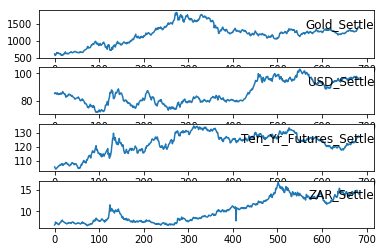

In [19]:
from matplotlib import pyplot
# load dataset
#dataset = read_csv('pollution.csv', header=0, index_col=0)
values = df1.values
# specify columns to plot
groups = [0, 1, 2, 3]
i = 1
# plot each column
pyplot.figure()
for group in groups:
	pyplot.subplot(len(groups), 1, i)
	pyplot.plot(values[:, group])
	pyplot.title(df1.columns[group], y=0.5, loc='right')
	i += 1
pyplot.show()

In [24]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg
 
# load dataset
#dataset = read_csv('pollution.csv', header=0, index_col=0)
values = df1.values
# integer encode direction
#encoder = LabelEncoder()
#values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[4,5,6,7]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)
1   0.036418   0.436486   0.045354   0.017171
2   0.000366   0.453635   0.024461   0.030911
3   0.012837   0.449883   0.000000   0.084123
4   0.020340   0.437772   0.001019   0.063979
5   0.051085   0.419016   0.003907   0.061446
